In [174]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

In [175]:
import json
sample_file_source = '/home/jupyter/data/dict/sample_file.txt'
with open(sample_file_source, "r") as f:
    sample_file_dict = json.load(f)
assert len(sample_file_dict) == 258

In [176]:
# import json
bbox_source = '/home/jupyter/data/dict/sample_bbox.txt'
with open(bbox_source, "r") as f:
    sample_bbox_dict = json.load(f)
assert len(sample_bbox_dict) == 258

In [177]:
sample_file_key = list(sample_bbox_dict.keys())[0]
print(f"sample_key: {sample_file_key}")
print(sample_file_dict[sample_file_key]['image'])
print(sample_bbox_dict[sample_file_key][0][1:])

sample_key: F0001_GM_M_D_75-45-18_07
/home/jupyter/data/aihub_sample/원천데이터/TS0001/B(외가)/1.Family/F0001_GM_M_D_75-45-18_07.JPG
['2306', '1283', '822', '822']


In [166]:
# 라벨링데이터 bbox 정보 정리
box_label=[]
for box in sample_bbox_dict[sample_file_key]:
    x_left = box[1]
    x_right = int(box[1])+int(box[3])
    y_left = box[2]
    y_right = int(box[2])+int(box[4])
    box_=list([int(x_left),int(y_left),int(x_right),int(y_right)])
    box_label.append(box_)
print(box_label)

[[2306, 1283, 3128, 2105], [3767, 1278, 4534, 2045], [802, 802, 1599, 1599]]


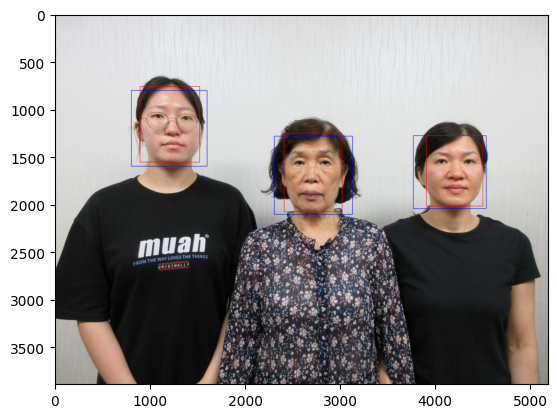

In [229]:
# 라벨링데이터이용해 바운딩박스그리기
img_dir = sample_file_dict[sample_file_key]['image']
img = Image.open(img_dir)
img = np.array(img)
# plt.imshow(img)
# draw = ImageDraw.Draw(img)
# def boxes_labels(img):
for box in sample_bbox_dict[sample_file_key]:
    x_left = box[1]
    x_right = int(box[1])+int(box[3])
    y_left = box[2]
    y_right = int(box[2])+int(box[4])
    img = cv2.rectangle(img, (int(x_left), int(y_left)), (int(x_right), int(y_right)), 
                        (0, 0, 255),3)
    # plt.imshow(img)

mtcnn_detect(img)
plt.imshow(img)

In [230]:
# mtcnn으로 multiple faces 인식

import cv2
from facenet_pytorch.models.mtcnn import MTCNN
import numpy as np
import torch
from PIL import Image, ImageDraw

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)
img_dir = sample_file_dict[sample_file_key]['image']
img = Image.open(img_dir)
# plt.imshow(img)
img = np.array(img)

def mtcnn_detect(img: np.ndarray) -> np.ndarray:
    boxes, probs = mtcnn.detect(img)
    # print(boxes)
    box_pred=[]
    for box in boxes:
        x_left = min(box[0], box[2])
        x_right = max(box[0], box[2])
        y_left = min(box[1], box[3])
        y_right = max(box[1], box[3])
        box_area = abs((box[2]-box[0])*(box[3]-box[1]))
        # print(box_area)
        if box_area<10000:
            continue
        img = cv2.rectangle(img, (int(x_left), int(y_left)), (int(x_right), int(y_right)), 
                            (255, 0, 0),3)
        box_=list([x_left,y_left,x_right,y_right])
        box_pred.append(box_)
    return box_pred

mtcnn_detect(img)

[[2421.317, 1258.0588, 3010.324, 2067.494],
 [907.50696, 774.4485, 1502.4475, 1556.3248],
 [3890.505, 1265.5051, 4489.734, 2018.3978]]

In [ ]:
[['2306', '1283', '822', '822'], ['3767', '1278', '767', '767'], ['802', '802', '797', '797']]
import torch

def Iou(bbox1, bbox2):
    # bbox shape = [x1, y1, x2, y2]
    x_topleft, y_topleft, x_bottomright, y_bottom
    # print('box_pred',bbox1)
    # print('box_label',bbox2)
    intersection_x1 = max(bbox1[0], bbox2[0])
    intersection_y1 = max(bbox1[1], bbox2[1])
    intersection_x2 = min(bbox1[2], bbox2[2])
    intersection_y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, intersection_x2-intersection_x1)*max(0, intersection_y2-intersection_y1) 
    # intersection = (intersection_x2 - intersection_x1).clamp(0) * (intersection_y2 - intersection_y1).clamp(0)
    # print(intersection)
    box1_area = abs((bbox1[2]-bbox1[0])*(bbox1[3]-bbox1[1]))
    box2_area = abs((bbox2[2]-bbox2[0])*(bbox2[3]-bbox2[1]))   
    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [186]:
def calc_iou(gt_bbox,pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area + 1e-6

In [214]:
x=mtcnn_detect(img)

In [184]:
Iou(x,box_label)

box_pred [2377.8718, 1265.4993, 3004.0276, 2095.0583]
box_label [2306, 1283, 3128, 2105]


0.7405240086078534

In [218]:
calc_iou(box_label[1],x[2])

0.7440479274378634

In [217]:
calc_iou(box_label[2],x[1])

0.6899256936291976

In [227]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    # print(gt_idx_thr)
    # print(pred_idx_thr)
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn,'iou':ious}

In [228]:
get_single_image_results(box_label, x, 0.5)

[0, 2, 1]
[0, 1, 2]


{'true_positive': 3,
 'false_positive': 0,
 'false_negative': 0,
 'iou': [0.7210251179696998, 0.6899256936291976, 0.7440479274378634]}

In [225]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [223]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
    for img_id in img_ids:
               
        gt_boxes_img = gt_boxes[img_id]
        box_scores = pred_boxes_pruned[img_id]['scores']
        start_idx = 0
        for score in box_scores:
            if score <= model_score_thr:
                pred_boxes_pruned[img_id]
                start_idx += 1
            else:
                break 
        # Remove boxes, scores of lower than threshold scores:
        pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
        pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
        # Recalculate image results for this image
        print(img_id)
        img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)
        # calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(      recall_level,"Recall Level")
            print(       args, "Args")
            print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
        avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [226]:
get_avg_precision_at_iou(box_label, x)

AttributeError: 'list' object has no attribute 'items'

# evalutation

In [ ]:
sample_file_key = list(sample_bbox_dict.keys())
for img_dir in sample_file_dict[sample_file_key]['image']:
    
print(sample_bbox_dict[sample_file_key])